In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
import seaborn as sn
import math
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [16]:
d_t = 0.01 #шаг по время
d_w = 0.01 #шаг окна
S_w_f = [lambda d: d[:,0].mean(), lambda d: d[:,0].mean()] #

In [17]:
n=12

In [18]:
#разбиваем файл на два(x и y) и находим начальное и последнее моменты времени (y)
def t_t_f(df):
    time_to_failure_x = df.values[:-1, 0]
    time_to_failure_y = df.values[:-1, 1]
    t0 = time_to_failure_y[-1]
    t1 = time_to_failure_y[0]
    return(t0, t1, time_to_failure_x, time_to_failure_y)

In [19]:
#нахождение индексов в сетке min max, чтобы окно не выходило за пределы имеющихся данных
def max_min(t0, t1):
    #с верхнего края
    #смотрим максимальный индекс в сетке
    it_max = math.floor(t1 / d_t)
    #подбираем индекс, чтобы мы находились внутри окна
    while d_t * it_max + d_w > t1:
        it_max -= 1
    #с нижнего края
    it_min = math.ceil(t0 / d_t)
    while d_t * it_min - d_w < t0:
        it_min += 1

    return(it_max, it_min)

In [20]:
def metrics(time_to_failure_y, time_to_failure_x, it_max, it_min):
    okno_time_to_failure = []
    sum_time_to_failure = []
    count_time_to_failure = []
    sum_count_time_to_failure = []
    i = 0
    sum = float(0.0)
    count = 0
    j = len(time_to_failure_y)
    b = 1
    #считаем мат ожидание
    for i in range(it_min, it_max+1):
        b = d_t*i

        while time_to_failure_y[j-1] <= b-d_t:
            j -= 1

        while time_to_failure_y[j-1] <= b:
            sum += time_to_failure_x[j-1]
            j-=1
            count += 1

        sum_time_to_failure.append(sum)
        sum = float(0.0)
        count_time_to_failure.append(count)
        count = 0

    for i in range(len(sum_time_to_failure)-1):
        okno_time_to_failure.append((sum_time_to_failure[i]+sum_time_to_failure[i+1])/(count_time_to_failure[i]+count_time_to_failure[i+1]))


    for i in range(len(count_time_to_failure)-1):
        sum_count_time_to_failure.append(count_time_to_failure[i]+count_time_to_failure[i+1])

    #подсчет значенией time_to_failure для окна
    okno_time_to_failure_y = []
    for i in range(it_min, it_max):
        okno_time_to_failure_y.append(i*d_t)

    #считаем дисперсию
    disp_sum_time_to_failure_1 = []
    disp_sum_time_to_failure_2 = []
    disp_okno_time_to_failure = []
    disp_sum_1 = 0
    disp_sum_2 = 0
    j = len(time_to_failure_x)
    b = 1
    k = len(time_to_failure_x)
    for i in range(it_min, it_max+1):
        b = d_t*i

        while time_to_failure_y[j-1] <= b-d_t:
            j -= 1

        while time_to_failure_y[j-1] <= b:
            if i < it_max:
                disp_sum_time_to_failure_1.append((time_to_failure_x[j-1] - okno_time_to_failure[i-it_min])**2)
            if i > it_min:
                disp_sum_time_to_failure_2.append((time_to_failure_x[j-1] - okno_time_to_failure[i-it_min-1])**2)
            j-=1

    for i in range(len(count_time_to_failure)-1):
        disp_okno_time_to_failure.append((disp_sum_time_to_failure_1[i] + disp_sum_time_to_failure_2[i])/(sum_count_time_to_failure[i]-1))

### все остальное

    three_okno_time_to_failure = []
    sum = 0
    b = 1
    i = 1
    k = 0
    j = len(time_to_failure_y)

    for i in range(it_min, it_max):
        b = d_t*i

        if k == 0:

            while time_to_failure_y[j-1] <= b-d_t:
                j -= 1

            while time_to_failure_y[j-1] <= b:
                sum += ((time_to_failure_x[j-1] - time_to_failure_x[i - it_min])**2 + (time_to_failure_y[j-1] - time_to_failure_y[i - it_min])**2)**(0.5)
                j-=1
                k = 1
        else:

            while time_to_failure_y[j-1] <= b-d_t:
                j -= 1

            while time_to_failure_y[j-1] <= b:
                sum += ((time_to_failure_x[j-1] - time_to_failure_x[i - it_min])**2 + (time_to_failure_y[j-1] - time_to_failure_y[i - it_min])**2)**(0.5)
                j-=1

        three_okno_time_to_failure.append(sum)
        sum = 0
        if k == 1 :
            sum = float(0.0)
            k = 0

    return(okno_time_to_failure, disp_okno_time_to_failure, three_okno_time_to_failure, okno_time_to_failure_y)


In [21]:
def table_x_y_3(okno_time_to_failure, disp_okno_time_to_failure, three_okno_time_to_failure, okno_time_to_failure_y, it_max, it_min):
    table_0 = pd.DataFrame(index=range(it_min, it_max), columns=range(len(S_w_f)), dtype='float64')
    table_0.insert(0, 'среднее', okno_time_to_failure)
    table_0.insert(1, 'дисперсия', disp_okno_time_to_failure)
    table_0.insert(2, 'расстояние', three_okno_time_to_failure)
    x_1 = table_0.drop(0, axis=1)
    X = x_1.drop(1, axis=1)

    y = pd.DataFrame(okno_time_to_failure_y)
    return(X, y)


In [22]:
#составляем таблицу для n*3 столбцов
def table_x_y_n(X, y, okno_time_to_failure, it_max, it_min, n):
    table = pd.DataFrame(index=range(it_min, it_max-n), columns=range(3*n), dtype='float64')
    for i in range(len(okno_time_to_failure)-n):
        for j in range(n):
            table[0+3*j].loc[table.index[i]] = X['среднее'].loc[X.index[i+j]]
            table[1+3*j].loc[table.index[i]] = X['дисперсия'].loc[X.index[i+j]]
            table[2+3*j].loc[table.index[i]] = X['расстояние'].loc[X.index[i+j]]


    #удаляем первые строки в у
    P = []
    for i in range(n):
        P.append(i)
    y_n = y.drop(index = P)

    return(table, y_n)

In [23]:
def f_n(df, n):
    t_0, t_1, t_x, t_y = t_t_f(df)
    it_max, it_min = max_min(t_0, t_1)
    m_1, m_2, m_3, m_4 = metrics(t_y, t_x, it_max, it_min)
    X, y = table_x_y_3(m_1, m_2, m_3, m_4, it_max, it_min)
    X_n, y_n = table_x_y_n(X, y, m_1, it_max, it_min, n)

    return(X_n, y_n)

In [24]:
#Что этот код делает? Почему тут X_n, y_n строяся по X, y
n = 4
df_1 = pd.read_csv('1.csv.gz', delimiter=',')
f_n(df_1, n)

(           0         1              2         3         4              5   \
 2    4.265972  0.000028  335510.183456  4.361681  0.000248  115723.624644   
 3    4.361681  0.000248  115723.624644  4.434416  0.000316  158960.291001   
 4    4.434416  0.000316  158960.291001  4.442023  0.000522  114365.444648   
 5    4.442023  0.000522  114365.444648  4.405762  0.000041  157898.206932   
 6    4.405762  0.000041  157898.206932  4.341707  0.000117  181614.718668   
 ..        ...       ...            ...       ...       ...            ...   
 136  5.055216  0.000139  200192.042896  4.932463  0.000097  121733.139938   
 137  4.932463  0.000097  121733.139938  4.790219  0.000117  209637.889839   
 138  4.790219  0.000117  209637.889839  4.722913  0.000008  164992.891428   
 139  4.722913  0.000008  164992.891428  4.759213  0.000363  142629.122146   
 140  4.759213  0.000363  142629.122146  4.740682  0.000082  118415.102517   
 
            6         7              8         9         10   

In [25]:
#статистические значения акустичесих данных первого эксперимента
df_1 = pd.read_csv('1.csv.gz', delimiter=',')
t_x = df_1['acoustic_data']
t_x.describe()

count    5.656574e+06
mean     4.560983e+00
std      2.342784e+01
min     -4.621000e+03
25%      2.000000e+00
50%      5.000000e+00
75%      7.000000e+00
max      3.252000e+03
Name: acoustic_data, dtype: float64

In [26]:
#статистические значения временных данных первого эксперимента
df_2 = pd.read_csv('1.csv.gz', delimiter=',')
t_y = df_2['time_to_failure']
t_y.describe()

count    5.656574e+06
mean     7.349829e-01
std      4.241720e-01
min      7.954798e-04
25%      3.678966e-01
50%      7.349977e-01
75%      1.102099e+00
max      1.469100e+00
Name: time_to_failure, dtype: float64

In [27]:
X_n

NameError: name 'X_n' is not defined

In [28]:
def regression(a, b):
    X_train, X_test, y_train, y_test = train_test_split(a, b, test_size = 0.2, random_state=42)
    linear_regression_model = linear_model.LinearRegression()
    linear_regression_model.fit(X_train, y_train)
    test_predictions = linear_regression_model.predict(X_test)
    R2 = r2_score(y_test, test_predictions)
    mae = mean_absolute_error(y_test, test_predictions)
    mse = mean_squared_error(y_test, test_predictions)

    return(y_test, test_predictions, R2, mae, mse)

In [29]:
def x_y(f, h):
    plt.figure(figsize=(7,7))
    plt.scatter(f, h)
    plt.axline((0,0),c = 'red', linestyle = '--',slope=1)
    plt.xlabel('Изначальный y', fontsize = 15)
    plt.ylabel('Предсказанный y',fontsize = 15)

    return()

In [70]:
def xgboost_(a, b):
    X_train, X_test, y_train, y_test = train_test_split(a,b, test_size = 0.2, random_state=42)
    xgb = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 2500)
    xgb.fit(X_train, y_train)
    test_predictions = xgb.predict(X_test)
    R2 = r2_score(y_test, test_predictions)
    mae = mean_absolute_error(y_test, test_predictions)
    mse = mean_squared_error(y_test, test_predictions)

    return(y_test, test_predictions, R2, mae, mse)

In [31]:
X_all = pd.read_csv('general_table_1_1.csv', delimiter=',')
y_all = pd.read_csv('general_table_target_1_1.csv', delimiter=',')


X_all = X_all.drop( columns=X_all.iloc[:, range(1)])
y_all = y_all.drop( 'Unnamed: 0', axis='columns')
X_all

,среднее,дисперсия,расстояние
0,4.486453,0.000031,144736.206724
1,4.425948,0.000159,157122.554909
2,4.507065,0.000359,139518.044657
3,4.603490,0.000187,169694.382883
4,4.580348,0.000032,133395.861407
...,...,...,...
16317,4.480754,0.000061,93362.101380
16318,4.389443,0.000238,149448.353708
16319,4.262014,0.000031,187646.392134
16320,4.230263,0.000390,93991.775929


In [32]:
general_table = X_all
general_table_target = y_all

In [33]:
#XGBOOST
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all, test_size = 0.2, random_state=42)
xgb = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 3500)
xgb.fit(X_train, y_train)
test_predictions = xgb.predict(X_test)
R2 = r2_score(y_test, test_predictions)
print(R2)

0.472104090434571


In [34]:
eps = 5
I = []
for i in range(len(general_table_target)):
    I.append(i)
l = len(I)

In [35]:
def cross_valid(eps, l, general_table, general_table_target):

    i_cv = []
    epsln = []
    #заполняем i_cv
    k = int(l/eps)
    for i in range(eps):
        for j in range(k):
            i_cv.append(i)

    m = l - k * eps

    for i in range(m):
        i_cv.append(eps-1)

    i_cv = np.array(i_cv)

    np.random.shuffle(i_cv)

    #считаем epsln
    for cvi in range(eps):
        model = linear_model.LinearRegression()
        model.fit(general_table.iloc[i_cv != cvi, :], general_table_target[i_cv != cvi])
        y_test = general_table_target[i_cv == cvi]
        y_pred = model.predict(general_table.iloc[i_cv == cvi, :])
        epsln.append(r2_score(y_test, y_pred))


    #считаем общее eps(all_eps)
    all_eps = 0
    for i in range(eps):
        all_eps += epsln[i]

    all_eps = all_eps / eps

    return all_eps

In [36]:
def cross_valid_xg(eps, l, general_table, general_table_target):

    i_cv = []
    epsln = []
    #заполняем i_cv
    k = int(l/eps)
    for i in range(eps):
        for j in range(k):
            i_cv.append(i)

    m = l - k * eps

    for i in range(m):
        i_cv.append(eps-1)

    i_cv = np.array(i_cv)

    np.random.shuffle(i_cv)

    #считаем epsln
    for cvi in range(eps):
        model = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 2500)
        model.fit(general_table.iloc[i_cv != cvi, :], general_table_target[i_cv != cvi])
        y_test = general_table_target[i_cv == cvi]
        y_pred = model.predict(general_table.iloc[i_cv == cvi, :])
        epsln.append(r2_score(y_test, y_pred))


    #считаем общее eps(all_eps)
    all_eps = 0
    for i in range(eps):
        all_eps += epsln[i]

    all_eps = all_eps / eps

    return (all_eps,y_test, y_pred)

In [37]:
e = cross_valid(eps, l, general_table, general_table_target)
e

0.30960797028388704

In [71]:
r_n_xgboost = xgboost_(general_table, general_table_target)
r_n_xgboost

(           0
 5922    2.25
 88     10.65
 12147   1.56
 2238    9.06
 381     2.00
 ...      ...
 9295    5.02
 7627   12.28
 3111    3.64
 4269    6.40
 4191    5.62
 
 [3265 rows x 1 columns],
 array([ 4.577916 , 10.495504 ,  2.3300154, ...,  5.5805163,  6.7860503,
         3.3275793], dtype=float32),
 0.48326103036374135,
 2.015287811040855,
 6.878163304496602)

In [39]:
eps = 5
I = []
for i in range(len(general_table_target)):
    I.append(i)
l = len(I)

e = cross_valid_xg(eps, l, general_table, general_table_target)
e

(0.5066116389158977,
            0
 0       9.77
 5       9.82
 10      9.87
 15      9.92
 16      9.93
 ...      ...
 16305  11.43
 16309  11.47
 16317  11.55
 16319  11.57
 16321  11.59
 
 [3266 rows x 1 columns],
 array([ 9.607228,  9.429751,  9.526122, ..., 11.629498, 11.267666,
        10.997794], dtype=float32))

In [40]:
X_all_n = pd.read_csv('general_table_1_1.csv', delimiter=',')
y_all_n = pd.read_csv('general_table_target_1_1.csv', delimiter=',')

In [41]:
e = cross_valid(eps, l, X_all_n, y_all_n)
e

0.9263726837544903

In [42]:
df_n_1 = pd.read_csv('1.csv.gz', delimiter=',')
X_1_n, y_1_n = f_n(df_n_1, n)
X_n_ = X_1_n
y_n_ = y_1_n

In [43]:
X_n_

,0,1,2,3,4,5,6,7,8,9,10,11
2,4.265972,0.000028,335510.183456,4.361681,0.000248,115723.624644,4.434416,0.000316,158960.291001,4.442023,0.000522,114365.444648
3,4.361681,0.000248,115723.624644,4.434416,0.000316,158960.291001,4.442023,0.000522,114365.444648,4.405762,0.000041,157898.206932
4,4.434416,0.000316,158960.291001,4.442023,0.000522,114365.444648,4.405762,0.000041,157898.206932,4.341707,0.000117,181614.718668
5,4.442023,0.000522,114365.444648,4.405762,0.000041,157898.206932,4.341707,0.000117,181614.718668,4.222941,0.000023,191449.407213
6,4.405762,0.000041,157898.206932,4.341707,0.000117,181614.718668,4.222941,0.000023,191449.407213,4.168521,0.000077,142450.105978
...,...,...,...,...,...,...,...,...,...,...,...,...
136,5.055216,0.000139,200192.042896,4.932463,0.000097,121733.139938,4.790219,0.000117,209637.889839,4.722913,0.000008,164992.891428
137,4.932463,0.000097,121733.139938,4.790219,0.000117,209637.889839,4.722913,0.000008,164992.891428,4.759213,0.000363,142629.122146
138,4.790219,0.000117,209637.889839,4.722913,0.000008,164992.891428,4.759213,0.000363,142629.122146,4.740682,0.000082,118415.102517
139,4.722913,0.000008,164992.891428,4.759213,0.000363,142629.122146,4.740682,0.000082,118415.102517,4.695788,0.000014,139479.341263


In [44]:
X_all_12_n = pd.read_csv('general_table_12_n.csv', delimiter=',')
y_all_12_n = pd.read_csv('general_table_target_12_n.csv', delimiter=',')


X_all_12_n = X_all_12_n.drop('Unnamed: 0', axis='columns')
y_all_12_n = y_all_12_n.drop('Unnamed: 0', axis='columns')
X_all_12_n

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,4.265972,0.000028,335510.183456,4.361681,0.000248,115723.624644,4.434416,0.000316,158960.291001,4.442023,...,382543.013653,4.258009,0.000200,114824.371426,4.208509,0.000002,142558.539806,4.367920,0.000008,136656.688920
1,4.361681,0.000248,115723.624644,4.434416,0.000316,158960.291001,4.442023,0.000522,114365.444648,4.405762,...,114824.371426,4.208509,0.000002,142558.539806,4.367920,0.000008,136656.688920,4.460051,0.000002,130974.567684
2,4.434416,0.000316,158960.291001,4.442023,0.000522,114365.444648,4.405762,0.000041,157898.206932,4.341707,...,142558.539806,4.367920,0.000008,136656.688920,4.460051,0.000002,130974.567684,4.423147,0.000014,125495.064647
3,4.442023,0.000522,114365.444648,4.405762,0.000041,157898.206932,4.341707,0.000117,181614.718668,4.222941,...,136656.688920,4.460051,0.000002,130974.567684,4.423147,0.000014,125495.064647,4.463906,0.000144,212107.247142
4,4.405762,0.000041,157898.206932,4.341707,0.000117,181614.718668,4.222941,0.000023,191449.407213,4.168521,...,130974.567684,4.423147,0.000014,125495.064647,4.463906,0.000144,212107.247142,4.439941,0.000186,117625.737727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16073,4.480867,0.000724,88983.601453,4.455374,0.000110,126495.824950,4.317713,0.000057,130859.580564,4.247481,...,84104.249081,4.147589,0.000084,184320.342172,4.257851,0.000415,110563.982422,4.410028,0.000159,156903.274808
16074,4.455374,0.000110,126495.824950,4.317713,0.000057,130859.580564,4.247481,0.000109,105653.872996,4.246291,...,184320.342172,4.257851,0.000415,110563.982422,4.410028,0.000159,156903.274808,4.480754,0.000061,93362.101380
16075,4.317713,0.000057,130859.580564,4.247481,0.000109,105653.872996,4.246291,0.000440,103866.809844,4.312474,...,110563.982422,4.410028,0.000159,156903.274808,4.480754,0.000061,93362.101380,4.389443,0.000238,149448.353708
16076,4.247481,0.000109,105653.872996,4.246291,0.000440,103866.809844,4.312474,0.000187,91286.610598,4.318398,...,156903.274808,4.480754,0.000061,93362.101380,4.389443,0.000238,149448.353708,4.262014,0.000031,187646.392134


In [45]:
X_all_8_n = pd.read_csv('general_table_8_n.csv', delimiter=',')
y_all_8_n = pd.read_csv('general_table_target_8_n.csv', delimiter=',')


X_all_8_n = X_all_8_n.drop('Unnamed: 0', axis='columns')
y_all_8_n = y_all_8_n.drop('Unnamed: 0', axis='columns')
X_all_8_n

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,4.265972,0.000028,335510.183456,4.361681,0.000248,115723.624644,4.434416,0.000316,158960.291001,4.442023,...,157898.206932,4.341707,0.000117,181614.718668,4.222941,0.000023,191449.407213,4.168521,0.000077,142450.105978
1,4.361681,0.000248,115723.624644,4.434416,0.000316,158960.291001,4.442023,0.000522,114365.444648,4.405762,...,181614.718668,4.222941,0.000023,191449.407213,4.168521,0.000077,142450.105978,4.258253,0.000014,382543.013653
2,4.434416,0.000316,158960.291001,4.442023,0.000522,114365.444648,4.405762,0.000041,157898.206932,4.341707,...,191449.407213,4.168521,0.000077,142450.105978,4.258253,0.000014,382543.013653,4.258009,0.000200,114824.371426
3,4.442023,0.000522,114365.444648,4.405762,0.000041,157898.206932,4.341707,0.000117,181614.718668,4.222941,...,142450.105978,4.258253,0.000014,382543.013653,4.258009,0.000200,114824.371426,4.208509,0.000002,142558.539806
4,4.405762,0.000041,157898.206932,4.341707,0.000117,181614.718668,4.222941,0.000023,191449.407213,4.168521,...,382543.013653,4.258009,0.000200,114824.371426,4.208509,0.000002,142558.539806,4.367920,0.000008,136656.688920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16141,4.246291,0.000440,103866.809844,4.312474,0.000187,91286.610598,4.318398,0.000085,141202.903730,4.292318,...,84104.249081,4.147589,0.000084,184320.342172,4.257851,0.000415,110563.982422,4.410028,0.000159,156903.274808
16142,4.312474,0.000187,91286.610598,4.318398,0.000085,141202.903730,4.292318,0.000007,98221.690403,4.227038,...,184320.342172,4.257851,0.000415,110563.982422,4.410028,0.000159,156903.274808,4.480754,0.000061,93362.101380
16143,4.318398,0.000085,141202.903730,4.292318,0.000007,98221.690403,4.227038,0.000187,84104.249081,4.147589,...,110563.982422,4.410028,0.000159,156903.274808,4.480754,0.000061,93362.101380,4.389443,0.000238,149448.353708
16144,4.292318,0.000007,98221.690403,4.227038,0.000187,84104.249081,4.147589,0.000084,184320.342172,4.257851,...,156903.274808,4.480754,0.000061,93362.101380,4.389443,0.000238,149448.353708,4.262014,0.000031,187646.392134


0.41167999369714825


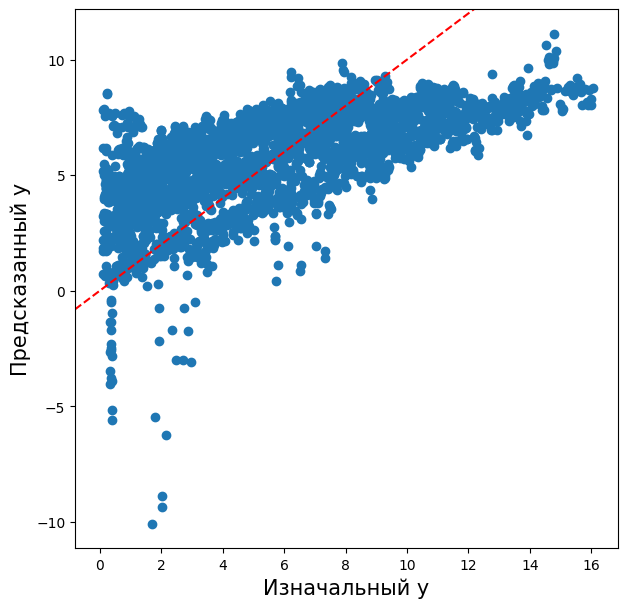

In [47]:
a, b, r, mae, mse = regression(X_all_8_n, y_all_8_n)
x_y(a, b)
print(r)

In [48]:
eps = 5
I = []
for i in range(len(y_all_8_n)):
    I.append(i)
l = len(I)

e = cross_valid(eps, l, X_all_8_n, y_all_8_n)
e

0.40397263703724706

In [72]:
r_n_xgboost = xgboost_(X_all_8_n, y_all_8_n)
r_n_xgboost

(       Unnamed: 0      0
 7013          716   7.18
 2271         1001  10.03
 751           624   6.26
 16024          61  10.38
 700           573   5.75
 ...           ...    ...
 744           617   6.19
 1965          695   6.97
 11984         135   1.37
 7207          910   9.12
 4149          598   6.00
 
 [3230 rows x 2 columns],
 array([[277.05566  ,   3.5403259],
        [798.51385  ,   9.042934 ],
        [442.7156   ,   4.1549745],
        ...,
        [271.46103  ,   2.2951038],
        [454.47473  ,   4.538765 ],
        [245.5757   ,   3.9232926]], dtype=float32),
 0.6914525401726578,
 79.52753685947701,
 22050.844442981685)

In [50]:
X_all_2_n = pd.read_csv('general_table_2_n.csv', delimiter=',')
y_all_2_n = pd.read_csv('general_table_target_2_n.csv', delimiter=',')

In [51]:
X_all_3_n = X_all_2_n.drop( 'Unnamed: 0', axis='columns')
X_all_3_n

,0,1,2,3,4,5,6,7,8,9,10,11
0,4.265972,0.000028,335510.183456,4.361681,0.000248,115723.624644,4.434416,0.000316,158960.291001,4.442023,0.000522,114365.444648
1,4.361681,0.000248,115723.624644,4.434416,0.000316,158960.291001,4.442023,0.000522,114365.444648,4.405762,0.000041,157898.206932
2,4.434416,0.000316,158960.291001,4.442023,0.000522,114365.444648,4.405762,0.000041,157898.206932,4.341707,0.000117,181614.718668
3,4.442023,0.000522,114365.444648,4.405762,0.000041,157898.206932,4.341707,0.000117,181614.718668,4.222941,0.000023,191449.407213
4,4.405762,0.000041,157898.206932,4.341707,0.000117,181614.718668,4.222941,0.000023,191449.407213,4.168521,0.000077,142450.105978
...,...,...,...,...,...,...,...,...,...,...,...,...
16209,4.227038,0.000187,84104.249081,4.147589,0.000084,184320.342172,4.257851,0.000415,110563.982422,4.410028,0.000159,156903.274808
16210,4.147589,0.000084,184320.342172,4.257851,0.000415,110563.982422,4.410028,0.000159,156903.274808,4.480754,0.000061,93362.101380
16211,4.257851,0.000415,110563.982422,4.410028,0.000159,156903.274808,4.480754,0.000061,93362.101380,4.389443,0.000238,149448.353708
16212,4.410028,0.000159,156903.274808,4.480754,0.000061,93362.101380,4.389443,0.000238,149448.353708,4.262014,0.000031,187646.392134


In [73]:
r_n_xgboost = xgboost_(X_all_3_n, y_all_2_n)
r_n_xgboost

(       Unnamed: 0      0
 1086          951   9.53
 13649          24   0.26
 2301         1019  10.21
 7039          710   7.12
 4885           52   0.54
 ...           ...    ...
 1981          699   7.01
 2144          862   8.64
 2848          155   1.57
 1880          598   6.00
 7801         1472  14.74
 
 [3243 rows x 2 columns],
 array([[ 932.41113  ,    8.367446 ],
        [ 139.11469  ,    1.8356888],
        [ 778.5677   ,    8.220875 ],
        ...,
        [  95.8347   ,    1.4292988],
        [ 613.40765  ,    5.628306 ],
        [1116.4084   ,    9.850414 ]], dtype=float32),
 0.6461385574019889,
 85.09184635092518,
 25470.309137840584)

In [53]:
eps = 5
I = []
for i in range(len(y_all_2_n)):
    I.append(i)
l = len(I)

e = cross_valid_xg(eps, l, X_all_3_n, y_all_2_n)
print(e)

(0.6612504852498179,        Unnamed: 0      0
3               7   0.09
13             17   0.19
19             23   0.25
22             26   0.28
25             29   0.31
...           ...    ...
16203         172  11.49
16204         173  11.50
16205         174  11.51
16206         175  11.52
16209         178  11.55

[3246 rows x 2 columns], array([[ 715.9988  ,    6.723976],
       [ 845.5757  ,    9.315457],
       [ 876.2738  ,    8.11713 ],
       ...,
       [ 292.03635 ,   11.643663],
       [-194.08954 ,    8.629788],
       [ 588.60944 ,   11.558137]], dtype=float32))


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_all_3_n,y_all_2_n, test_size = 0.2, random_state=42)
clf = linear_model.Lasso(alpha=e[0])
clf.fit(X_train, y_train)
test_predictions = clf.predict(X_test)
R2 = r2_score(y_test, test_predictions)
R2


0.35440127526898535

In [55]:
def lasso(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    clf = linear_model.Lasso(alpha=1)
    clf.fit(X_train, y_train)
    test_predictions = clf.predict(X_test)
    R2 = r2_score(y_test, test_predictions)
    return(y_test, test_predictions, R2)

0.2979295244360728
124.72429697049996
48819.16368071332


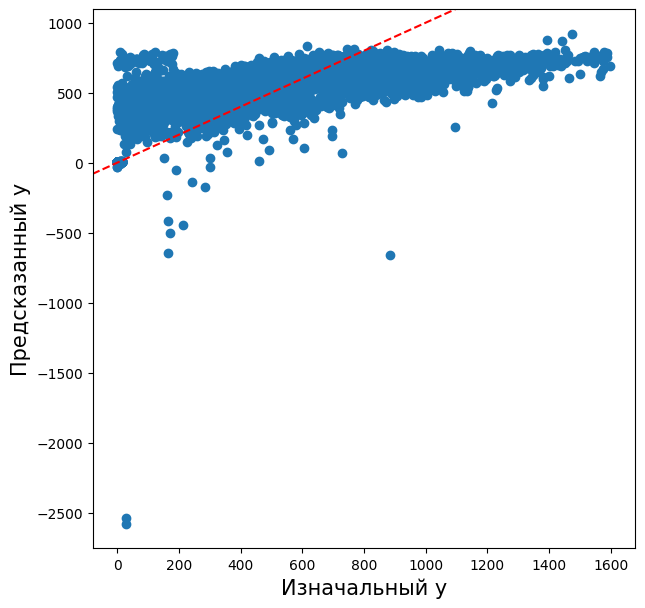

In [56]:
X_all_1_1 = pd.read_csv('general_table_1_1.csv', delimiter=',')
y_all_1_1 = pd.read_csv('general_table_target_1_1.csv', delimiter=',')
X_all_1_1 = X_all_1_1.drop( 'Unnamed: 0', axis='columns')

X_1, y_1, r_1, mae_1, mse_1 = regression(X_all_1_1, y_all_1_1)
x_y(X_1,y_1)
print(r_1)
print(mae_1)
print(mse_1)


0.29465304918737234


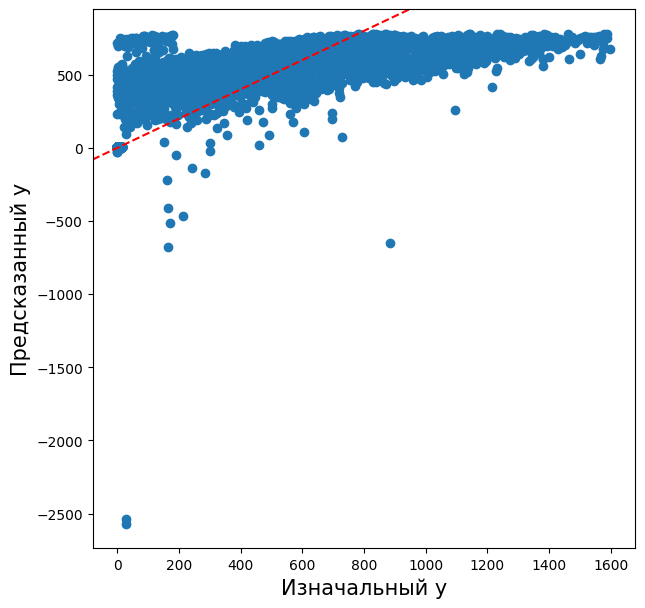

In [57]:
X_all_1_1 = pd.read_csv('general_table_1_1.csv', delimiter=',')
y_all_1_1 = pd.read_csv('general_table_target_1_1.csv', delimiter=',')
X_all_1_1 = X_all_1_1.drop( 'Unnamed: 0', axis='columns')

X_1, y_1, r_1 = lasso(X_all_1_1, y_all_1_1)
x_y(X_1,y_1)
print(r_1)

0.3598333488700473
121.40057603358622
44829.399024635866


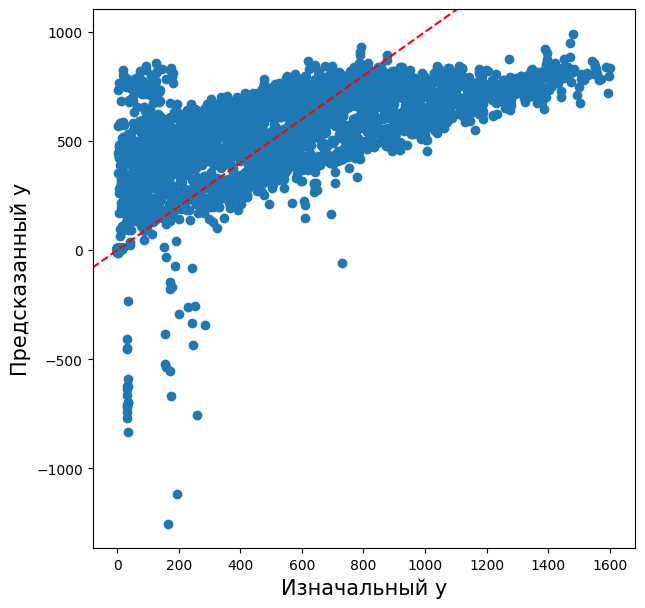

In [58]:
X_all_4_n = pd.read_csv('general_table_2_n.csv', delimiter=',')
y_all_4_n = pd.read_csv('general_table_target_2_n.csv', delimiter=',')
X_all_4_n = X_all_4_n.drop( 'Unnamed: 0', axis='columns')

X_2, y_2, r_2, mae_2, mse_2 = regression(X_all_4_n, y_all_4_n)
x_y(X_2,y_2)
print(r_2)
print(mae_2)
print(mse_2)

0.3543770303188656


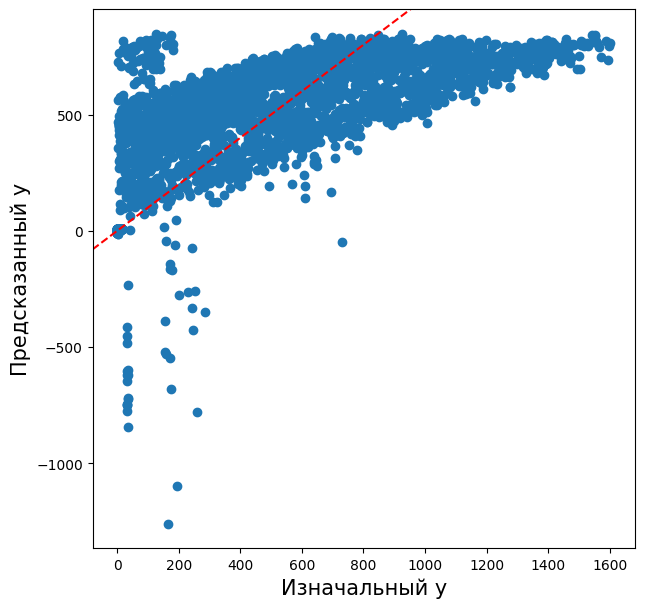

In [59]:
X_all_4_n = pd.read_csv('general_table_2_n.csv', delimiter=',')
y_all_4_n = pd.read_csv('general_table_target_2_n.csv', delimiter=',')
X_all_4_n = X_all_4_n.drop( 'Unnamed: 0', axis='columns')

X_2, y_2, r_2 = lasso(X_all_4_n, y_all_4_n)
x_y(X_2,y_2)
print(r_2)

0.3904163000265306
117.9034636350036
41817.94526818704


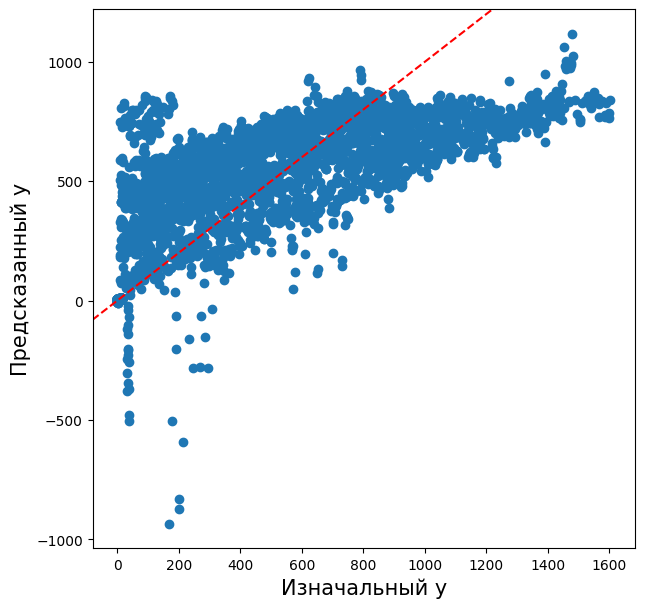

In [60]:
X_all_8_n = pd.read_csv('general_table_8_n.csv', delimiter=',')
y_all_8_n = pd.read_csv('general_table_target_8_n.csv', delimiter=',')
X_all_8_n = X_all_8_n.drop( 'Unnamed: 0', axis='columns')

X_3, y_3, r_3, mae_3, mse_3 = regression(X_all_8_n, y_all_8_n)
x_y(X_3,y_3)
print(r_3)
print(mae_3)
print(mse_3)

0.38427229208228686


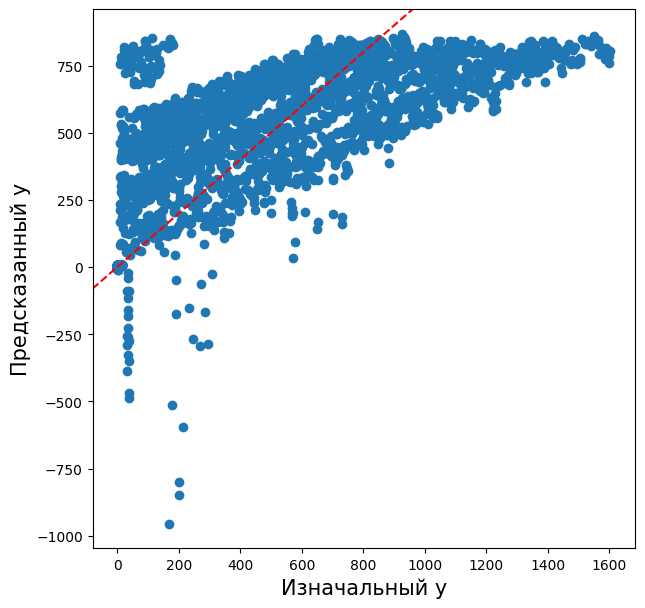

In [ ]:
X_all_8_n = pd.read_csv('general_table_8_n.csv', delimiter=',')
y_all_8_n = pd.read_csv('general_table_target_8_n.csv', delimiter=',')
X_all_8_n = X_all_8_n.drop( 'Unnamed: 0', axis='columns')

X_3, y_3, r_3 = lasso(X_all_8_n, y_all_8_n)
x_y(X_3,y_3)
print(r_3)

0.41765000876533187
115.32358562445808
39679.98502849488


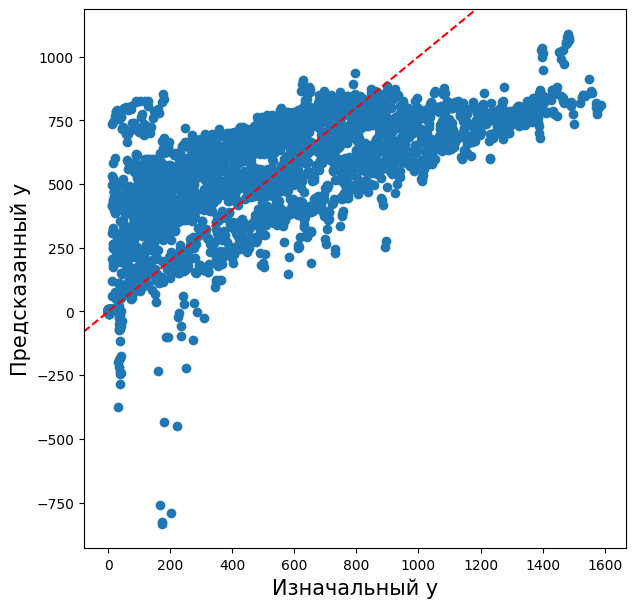

In [61]:
X_all_12_n = pd.read_csv('general_table_12_n.csv', delimiter=',')
y_all_12_n = pd.read_csv('general_table_target_12_n.csv', delimiter=',')
X_all_12_n = X_all_12_n.drop( 'Unnamed: 0', axis='columns')

X_4, y_4, r_4, mae_4, mse_4 = regression(X_all_12_n, y_all_12_n)
x_y(X_4,y_4)
print(r_4)
print(mae_4)
print(mse_4)

0.4048036947286477


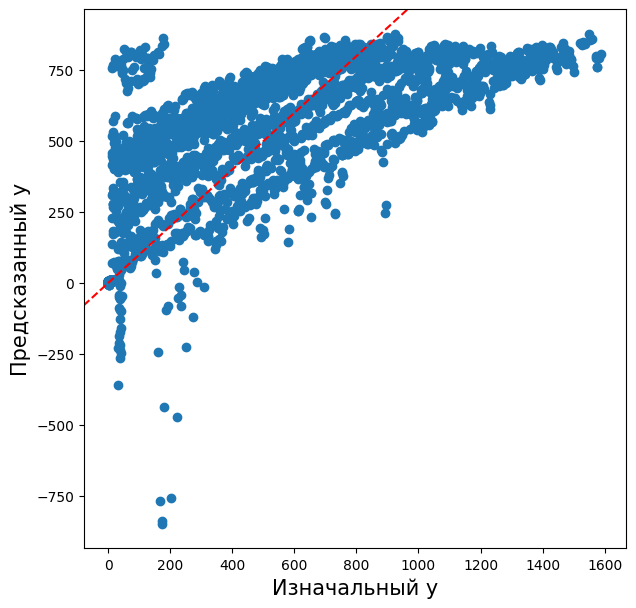

In [62]:
X_all_12_n = pd.read_csv('general_table_12_n.csv', delimiter=',')
y_all_12_n = pd.read_csv('general_table_target_12_n.csv', delimiter=',')
X_all_12_n = X_all_12_n.drop( 'Unnamed: 0', axis='columns')

X_4, y_4, r_4 = lasso(X_all_12_n, y_all_12_n)
x_y(X_4,y_4)
print(r_4)

0.4811360374480725
102.06691672742217
34551.481572163975


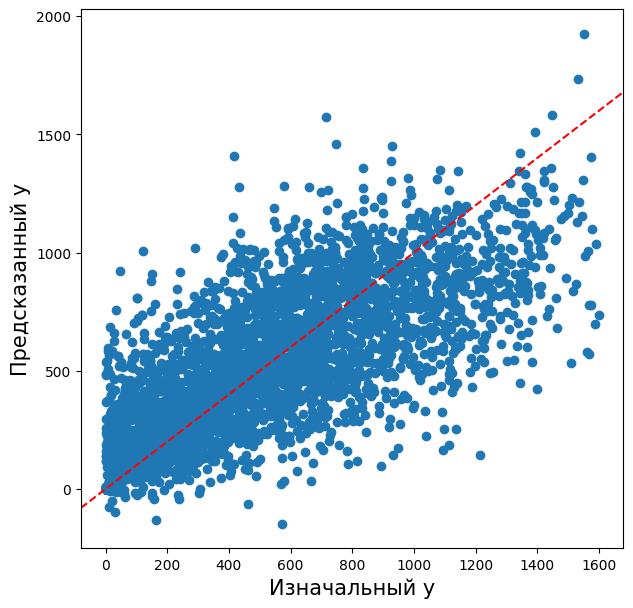

In [74]:
X_all_1_1 = pd.read_csv('general_table_1_1.csv', delimiter=',')
y_all_1_1 = pd.read_csv('general_table_target_1_1.csv', delimiter=',')
X_all_1_1 = X_all_1_1.drop( 'Unnamed: 0', axis='columns')

X, y, r_1, mae_1, mse_1 = xgboost_(X_all_1_1, y_all_1_1)
x_y(X,y)
print(r_1)
print(mae_1)
print(mse_1)

0.4846207217059346

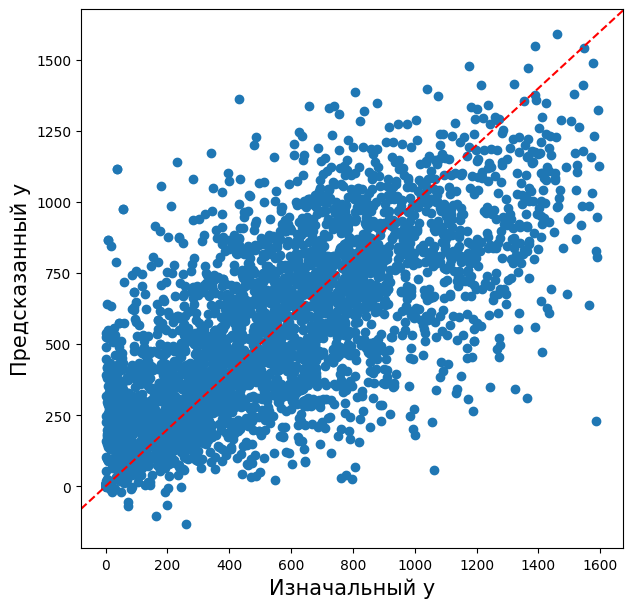

In [64]:
X_all_1_1 = pd.read_csv('general_table_1_1.csv', delimiter=',')
y_all_1_1 = pd.read_csv('general_table_target_1_1.csv', delimiter=',')
X_all_1_1 = X_all_1_1.drop( 'Unnamed: 0', axis='columns')

eps = 5
I = []
for i in range(len(y_all_1_1)):
    I.append(i)
l = len(I)
e, X, y = cross_valid_xg(eps, l, X_all_1_1, y_all_1_1)
x_y(X,y)
e

0.6461385574019889
85.09184635092518
25470.309137840584


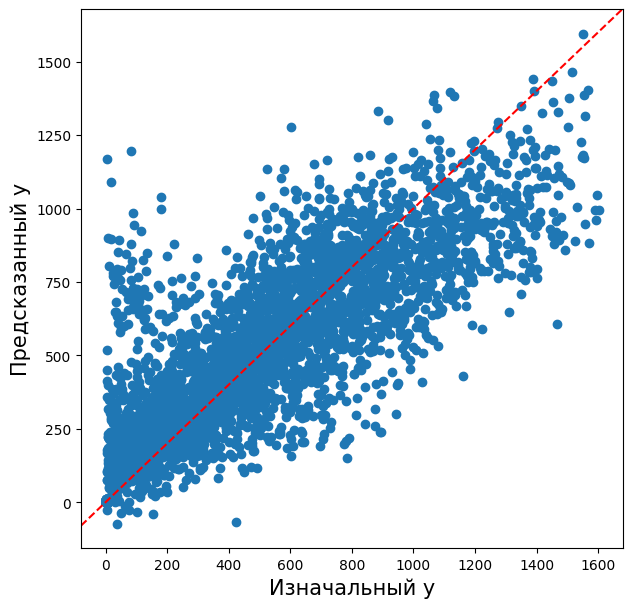

In [75]:
X_all_4_n = pd.read_csv('general_table_2_n.csv', delimiter=',')
y_all_4_n = pd.read_csv('general_table_target_2_n.csv', delimiter=',')
X_all_4_n = X_all_4_n.drop( 'Unnamed: 0', axis='columns')

X, y, r_2, mae_2, mse_2 = xgboost_(X_all_4_n, y_all_4_n)
x_y(X,y)
print(r_2)
print(mae_2)
print(mse_2)

0.6628543872388255

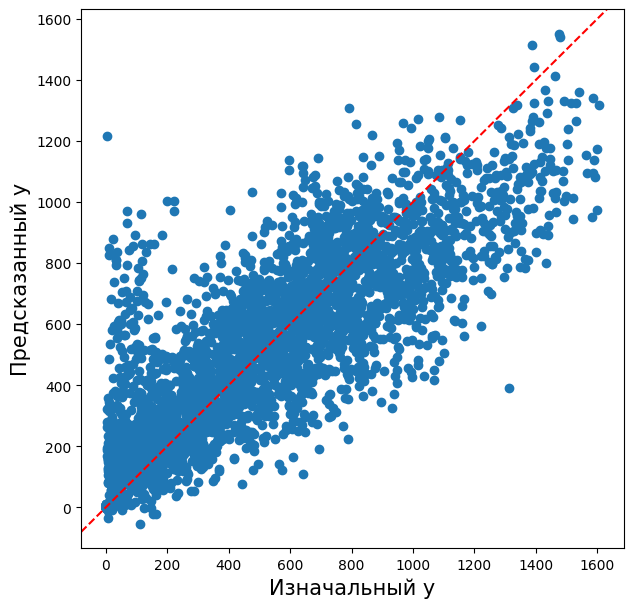

In [ ]:
X_all_4_n = pd.read_csv('general_table_2_n.csv', delimiter=',')
y_all_4_n = pd.read_csv('general_table_target_2_n.csv', delimiter=',')
X_all_4_n = X_all_4_n.drop( 'Unnamed: 0', axis='columns')

eps = 5
I = []
for i in range(len(y_all_4_n)):
    I.append(i)
l = len(I)
e, X, y = cross_valid_xg(eps, l, X_all_4_n, y_all_4_n)
x_y(X,y)
e

0.6914525401726578
79.52753685947701
22050.844442981685


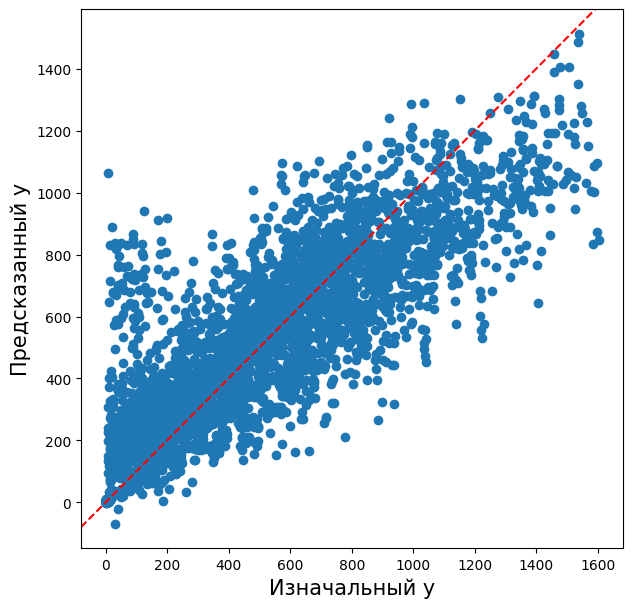

In [77]:
X_all_8_n = pd.read_csv('general_table_8_n.csv', delimiter=',')
y_all_8_n = pd.read_csv('general_table_target_8_n.csv', delimiter=',')
X_all_8_n = X_all_8_n.drop( 'Unnamed: 0', axis='columns')

X, y, r_3, mae_3, mse_3 = xgboost_(X_all_8_n, y_all_8_n)
x_y(X,y)
print(r_3)
print(mae_3)
print(mse_3)

0.7066221890441085

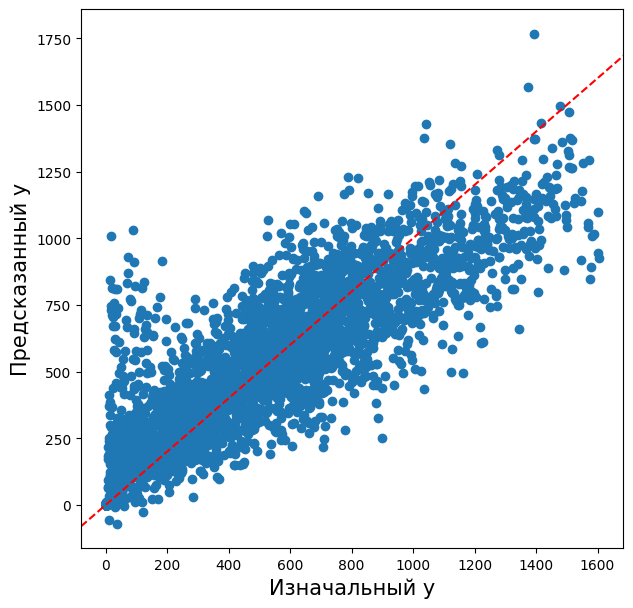

In [ ]:
X_all_8_n = pd.read_csv('general_table_8_n.csv', delimiter=',')
y_all_8_n = pd.read_csv('general_table_target_8_n.csv', delimiter=',')
X_all_8_n = X_all_8_n.drop( 'Unnamed: 0', axis='columns')

eps = 5
I = []
for i in range(len(y_all_8_n)):
    I.append(i)
l = len(I)
e, X, y = cross_valid_xg(eps, l, X_all_8_n, y_all_8_n)
x_y(X,y)
e

0.7215493509270787
75.55991720421946
19509.341631471696


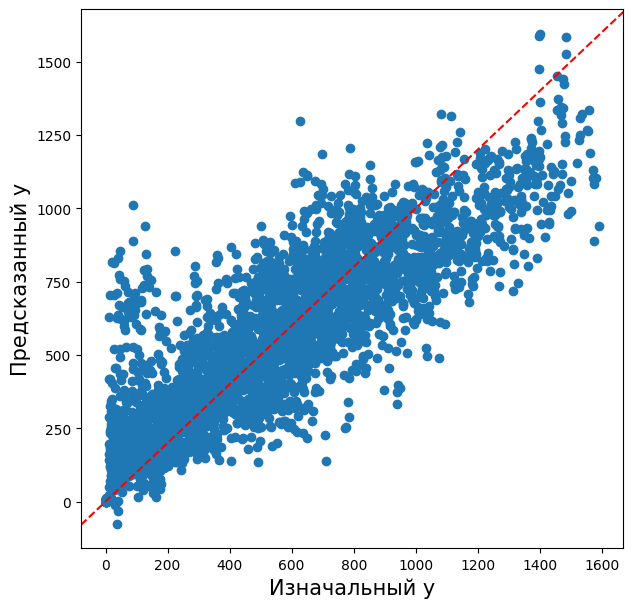

In [76]:
X_all_12_n = pd.read_csv('general_table_12_n.csv', delimiter=',')
y_all_12_n = pd.read_csv('general_table_target_12_n.csv', delimiter=',')
X_all_12_n = X_all_12_n.drop( 'Unnamed: 0', axis='columns')

X, y, r_4, mae_4, mse_4 = xgboost_(X_all_12_n, y_all_12_n)
x_y(X,y)
print(r_4)
print(mae_4)
print(mse_4)


0.7249125383592632

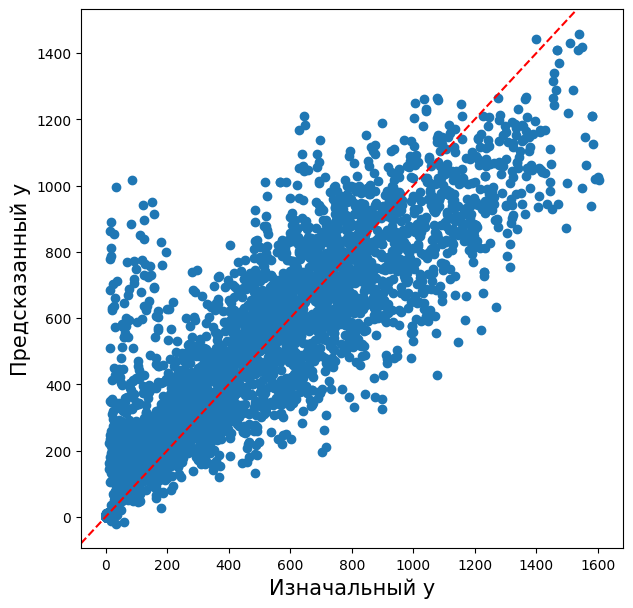

In [66]:
X_all_12_n = pd.read_csv('general_table_12_n.csv', delimiter=',')
y_all_12_n = pd.read_csv('general_table_target_12_n.csv', delimiter=',')
X_all_12_n = X_all_12_n.drop( 'Unnamed: 0', axis='columns')

eps = 5
I = []
for i in range(len(y_all_12_n)):
    I.append(i)
l = len(I)
e, X, y = cross_valid_xg(eps, l, X_all_12_n, y_all_12_n)
x_y(X,y)
e